In [6]:
import sys
 
import tensorflow.keras
import tensorflow as tf
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.9.17 (main, Jul  5 2023, 20:41:20) 
[GCC 11.2.0]
GPU is available


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pdb
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout, Input, MaxPool2D , Flatten
import cv2
import imgaug.augmenters as iaa
from PIL import Image, ImageDraw
from PIL import ImagePath
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve,precision_recall_curve, auc , multilabel_confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0 , EfficientNetB4 , EfficientNetB7
import tensorflow as tf
from tensorflow.keras.utils import to_categorical ,Sequence
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from numpy import save ,load

env: SM_FRAMEWORK=tf.keras


In [8]:
train_images_path = 'Severstaldataset-20230720T140741Z-001/Severstaldataset/train_images'
#train_masks_path = 'Severstaldataset-20230720T140741Z-001/Severstaldataset/train_masks'
train_image_names = os.listdir(train_images_path)
train_masks_npy_path = 'Severstaldataset-20230720T140741Z-001/Severstaldataset/train_masks_npy'
train_df = pd.read_csv('Severstaldataset-20230720T140741Z-001/Severstaldataset/train.csv')

In [9]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum,fill_value= ' ').astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,,,
3,000f6bf48.jpg,,,,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,,,229501 11 229741 33 229981 55 230221 77 230468...,


In [10]:
# 'hasDefect' column indicates if there is atleast one defect in the image
insert_column = []
for i in range(len(train_data)):
    if (train_data['Defect_1'][i]== ' ' and train_data['Defect_2'][i]== ' ' and train_data['Defect_3'][i]==' ' and train_data['Defect_4'][i]==' '):
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect'] = insert_column

# 'hasDefect_1' column indicates if there is type 1 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_1'] = insert_column

# 'hasDefect_2' column indicates if there is type 2 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_2'] = insert_column

# 'hasDefect_3' column indicates if there is type 3 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_3'] = insert_column

# 'hasDefect_4' column indicates if there is type 4 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_4'] = insert_column

train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,,,,1,1,0,0,0
3,000f6bf48.jpg,,,,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1,0,0,0,1
4,0014fce06.jpg,,,229501 11 229741 33 229981 55 230221 77 230468...,,1,0,0,1,0


In [11]:
insert_column = []
for i in range(len(train_data)):
    if train_data['hasDefect_2'].iloc[i]==1:
        insert_column.append(2)
    elif train_data['hasDefect_4'].iloc[i]==1:
        insert_column.append(4)
    elif train_data['hasDefect_1'].iloc[i]==1:
        insert_column.append(1)
    elif train_data['hasDefect_3'].iloc[i]==1:
        insert_column.append(3)
    else:
        insert_column.append(0)
train_data['minority_preference']= insert_column
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4,minority_preference
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0,1
1,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0,3
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,,,,1,1,0,0,0,1
3,000f6bf48.jpg,,,,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1,0,0,0,1,4
4,0014fce06.jpg,,,229501 11 229741 33 229981 55 230221 77 230468...,,1,0,0,1,0,3


In [12]:
X_train, X_test = train_test_split(train_data, test_size = 0.2, stratify = train_data['minority_preference'],random_state=15)
print(X_train.shape, X_test.shape)

(5332, 11) (1334, 11)


In [13]:
colourmap = [[0, 0, 0], [255, 105, 180], [ 180,255,105],[ 105, 180,255], [255, 255,105]]
classes_tocolour =   dict({0: [0, 0, 0], 1: [255, 105, 180], 2:  [180,255,105], 3:[105, 180,255], 4: [ 255, 255,105]})
classes = [0,1,2,3,4]  

In [14]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2_1frame(mask_rle_list, shape=(1600,256)):
    '''
    mask_rle: list of strings(run-length as string formated (start length)), each for 1,2,3,4 defects 
    shape: (width,height) of array to return 
    Returns 2 D numpy array. 0 for no defect, 1 defect 1 , 2 for defect 2 , 3 for defect 3 and 4 for defect 4
    This function is specific to this competition
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)    
    for i in range(len(mask_rle_list)):
      if mask_rle_list[i] != ' ' :
        sp = mask_rle_list[i].split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (sp[0:][::2], sp[1:][::2])]
        starts -= 1
        ends = starts + lengths
        # pdb.set_trace()
        for lo, hi in zip(starts, ends):
            img[lo:hi] = i+1 
    img = img.reshape(shape).T      
    return img #256 * 1600

In [15]:
def rle_to_RGBmask(mask_rle_list, classes_tocolour ,shape=(1600,256)):
  ''' 
  This function will save the RGB masks from RLE
  '''
  img = rle2_1frame(mask_rle_list, shape=(1600,256))
  # pdb.set_trace()
  #Till here we got 256 X 1600 and now we have to convert this matrix to an RGB encoded mask
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))  
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3 

In [16]:
def RGBmask_to_width_height_classes ( rgb_mask , colourmap ):
  ''' 
  This function will convert the RGB mask to width X height X classes
  '''
  output_mask = []
  for i , color in enumerate(colourmap): 
    cmap = np.all(np.equal(rgb_mask , color ), axis = -1)
    cmap.astype(int)  
    output_mask.append(cmap)
  output_mask = np.stack(output_mask , axis = -1)
  output_mask = output_mask.astype(np.uint8)
  return output_mask #output will have five channels. any pixel will have 1 in any one of the 5 channels 

In [17]:
def width_height_classes_toRGB(img,classes_tocolour):
  ''' Given an widthXheightXclasses we need to convert into an RGB image 256X1600X5  to 256 X 1600 X 3'''
  img = np.argmax(img,axis= -1) #256 X 1600
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))  
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3 

In [18]:
def one_frame_rgb(img,classes_tocolour):
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))  
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3 

In [19]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.Iou_score =[]
        self.val_iou_score = []
        plt.figure(figsize=(35, 7))
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.Iou_score.append(logs.get('iou_score'))
        self.val_iou_score.append(logs.get('val_iou_score'))
        self.i += 1
        clear_output(wait=True)
        x = PrettyTable()
        x.add_column("Epoch",self.x)
        x.add_column("Loss",self.losses)
        x.add_column("Val_Loss",self.val_losses)
        x.add_column("Iou Scrore",self.Iou_score)
        x.add_column("Val_Iou Scrore",self.val_iou_score)
        print(x)
        plt.subplot(121)
        plt.plot(self.x, self.Iou_score, label="Iou_Score")
        plt.plot(self.x, self.val_iou_score, label="val_Iou_Score")        
        plt.title('Model iou_score')
        plt.ylabel('iou_score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        

        plt.subplot(122)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()      
plot_losses = PlotLosses()

In [20]:
def plot_confusion_matrix(test_y,predict_y,target_names): 
    '''For the predicted and actual y, we will print the confusion matrix'''
    CM = multilabel_confusion_matrix(test_y, predict_y)  # 5 2X2
    # pdb.set_trace()
    for i in range(len(target_names)):
      C = CM[i,:,:]
      print("Confusion , Precision and recall matrices for {}".format(target_names[i]))
      R =(((C.T)/(C.sum(axis=1))).T)
      #divid each element of the confusion matrix with the sum of elements in that column
    
      P =(C/C.sum(axis=0))
      #divid each element of the confusion matrix with the sum of elements in that row

      plt.figure(figsize=(20,2))
    
      labels = [0,1]
      cmap=sns.light_palette("blue")
      plt.subplot(1, 3, 1)
      sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Confusion matrix")
    
      plt.subplot(1, 3, 2)
      sns.heatmap(P, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Precision matrix")
      
      plt.subplot(1, 3, 3)
      sns.heatmap(R, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Recall matrix")
      plt.show()

In [22]:
class Unet_efficnetB0 :
  def __init__(self,input_shape,classes):
    tf.keras.backend.clear_session()
    self.input_shape = input_shape
    self.classes = classes
    self.inputs = Input(input_shape)
    self.encoder = EfficientNetB0(include_top=False, weights='imagenet', input_tensor= self.inputs)

  def conv_block(self,inputs,num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

  def decoder_block(self,inputs,skip, num_filters):
      x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
      x = Concatenate()([x, skip])
      x = self.conv_block(x, num_filters)
      return x

  def build_efficient_unet(self):
    
    s1 = self.encoder.get_layer("input_1").output  #skip connection 256X1600 

    s2 = self.encoder.get_layer("block2a_expand_activation").output  #skip connection 128X800

    s3 = self.encoder.get_layer("block3a_expand_activation").output  #skip connection 64X400

    s4 = self.encoder.get_layer("block4a_expand_activation").output  #skip connection 32X200

    """ Bottle neck"""

    b1 = self.encoder.get_layer("block6a_expand_activation").output  # 16X100

    """decoder block"""
    d1 = self.decoder_block(b1,s4,512) #32 X 200 X 512 

    d2 = self.decoder_block(d1,s3,256) #64 X 400 X 256

    d3 = self.decoder_block(d2,s2,128) #128 X 800 X 128
  
    d4 = self.decoder_block(d3,s1,64) #256 X 1600 X 128

    """Output"""
    outputs = Conv2D(self.classes,1,padding = "same" , activation= "softmax")(d4) 
    
    unet_model = Model(self.inputs , outputs, name = "EfficientNetB0_UNET") 

    return  unet_model
if __name__ == "__main__" :
  input_shape  = (256,1600,3)
  ueff = Unet_efficnetB0(input_shape = input_shape,classes = 5 )
  unet_model = ueff.build_efficient_unet()
  unet_model.load_weights('Severstaldataset-20230720T140741Z-001/Severstaldataset/best_multi_class_model.h5') 

In [23]:
def final_fun_1(X) :
    ''' Takes  ImageID  and do image segmentation for different type of defects'''
    ImageId= os.path.join(train_images_path,X) 
    img = cv2.imread(ImageId)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X1
    return predict_mask

Images and original mask and predicted mask
1/1 [==============================] - 24s 24s/step


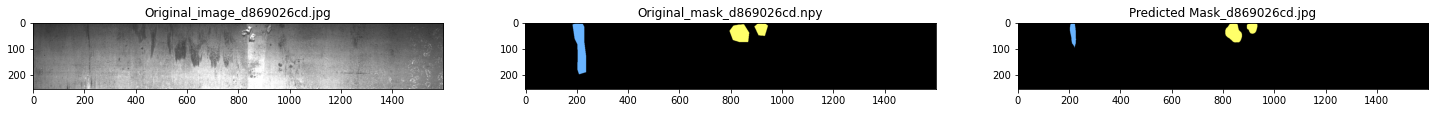

1/1 [==============================] - 0s 42ms/step


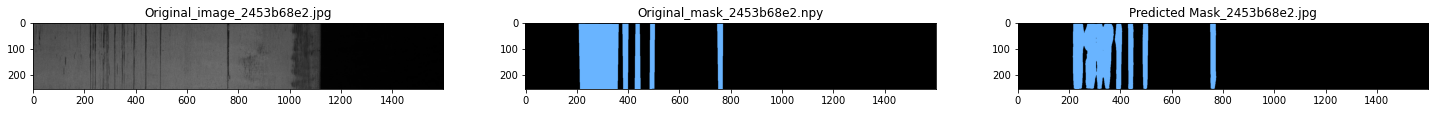

1/1 [==============================] - 0s 33ms/step


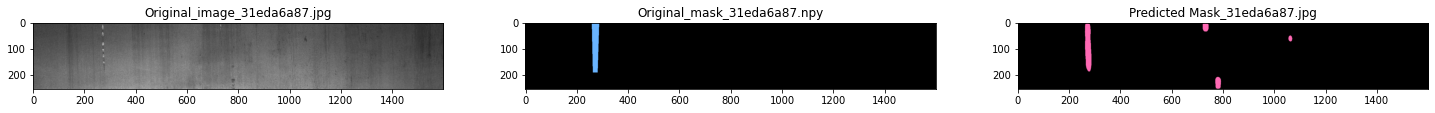

1/1 [==============================] - 0s 120ms/step


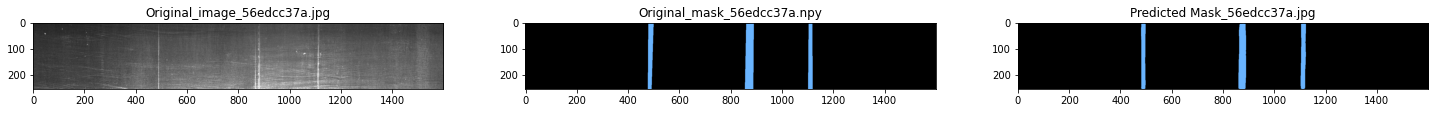

1/1 [==============================] - 0s 28ms/step


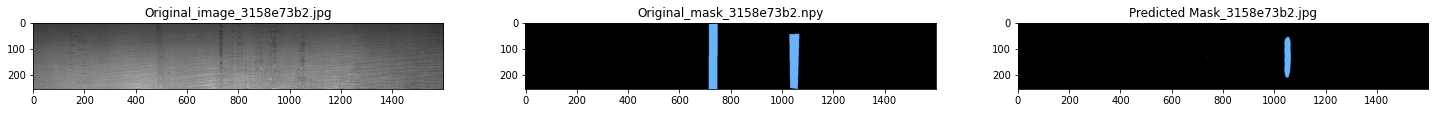

1/1 [==============================] - 0s 32ms/step


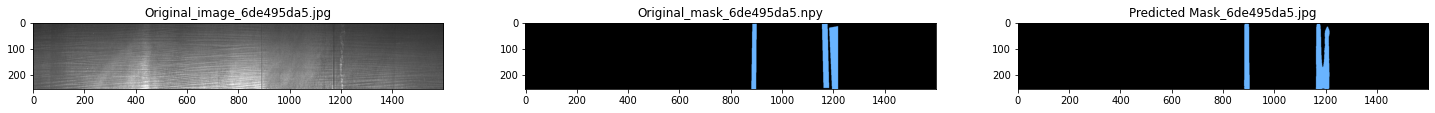

1/1 [==============================] - 0s 35ms/step


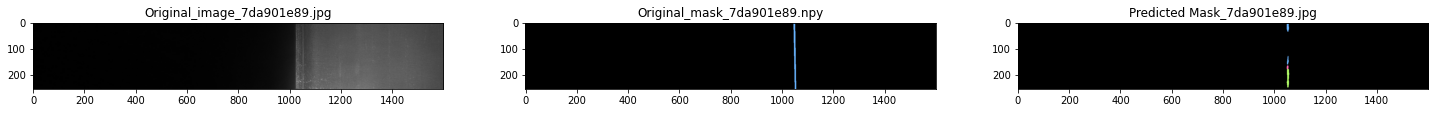

1/1 [==============================] - 0s 30ms/step


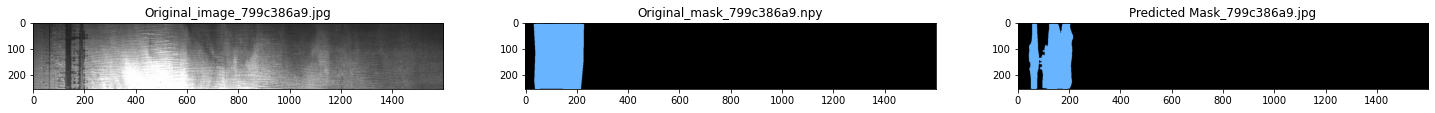

1/1 [==============================] - 0s 31ms/step


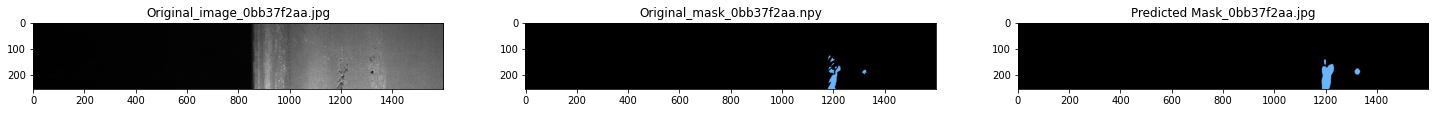

1/1 [==============================] - 0s 32ms/step


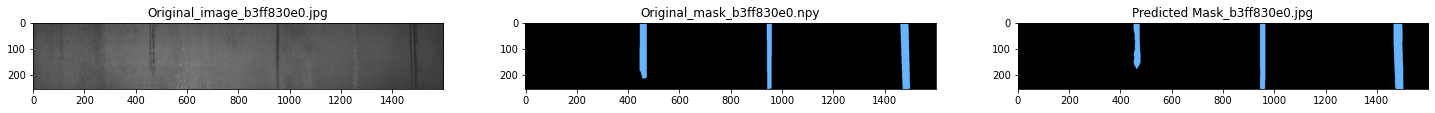

--------------------------------------------------------------------------------


In [24]:
# # Visualization: Sample original and predicted masks
print('Images and original mask and predicted mask')
X_test_sampple = X_test.sample(n=10)
for i in X_test_sampple['ImageId'].values :
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(os.path.join(train_images_path,i))
    ax1.imshow(img)
    ax1.set_title('Original_image_'+i)
    file_name = i.split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600 X 5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+file_name) 
    
    predict_mask = final_fun_1(i)
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour) #256 X 1600 X 3
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+i)
    plt.show() 
print('-'*80)

In [25]:
def IOU(original,predicted):
  '''given original and predicted images ( numpy masks (256X1600X5)) will return the IOU score'''
  intersection = original == predicted
  union = 256*1600
  return np.sum(intersection) / union

In [26]:
def final_fun_2(X) :
  ''' for the data frame given, need to predict the masks and compare the masks with original masks and print the final IOU score'''
  # pdb.set_trace()
  original_mask = np.load(os.path.join(train_masks_npy_path, X.split('.')[0]+'.npy')) 
  original_mask = np.argmax(original_mask,axis= -1)
  ImageId= os.path.join(train_images_path,X) 
  img = cv2.imread(ImageId)
  predict_mask = unet_model.predict(np.expand_dims(img, axis=0)) #256X1600X5 
  predict_mask = np.squeeze(np.argmax(predict_mask,axis= -1),axis = 0 )
  return IOU(original_mask,predict_mask)

In [27]:
IOU_scores = []
for i in X_test['ImageId'].values :
  IOU_scores.append(final_fun_2(i))
IOU_scores = np.array(IOU_scores)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


In [28]:
print('IOU score for test data is {}'.format(np.mean(IOU_scores)))

IOU score for test data is 0.9606202672589484
